# **Deep Learning Volume Segmentation (3D UNet)**

Authors: Anna Ekner (s193396@dtu.dk)

This notebook aims to demonstrate the feasibility of implementing a comprehensive deep learning segmentation pipeline solely leveraging the capabilities offered by the `qim3d` library. Specifically, it highlights the use of the synthetic data generation functionalities to create a volumetric dataset with associated labels, and walks through the process of creating and training a 3D UNet model using this synthetic dataset.

In [11]:
import qim3d
import os

### **1. Generate synthetic dataset**

The `qim3d` library provides methods for generating 3D synthetic data and corresponding masks through the `qim3d.generate` module, which can be used to train segmentation models. This notebook is designed to demonstrate the segmentation pipeline, and the synthetic dataset can be replaced with any dataset suitable for the specific segmentation task. It is important to note that, for training a deep learning model, the dataset must include both 1) raw 3D volumes, and 2) the corresponding 3D masks where the structures of interest have been segmented (i.e. ground truth labels).

##### **1.1 Create dataset folder structure**

The dataset for training the model expects files to follow this structure:

<pre>
dataset
├── train
│   ├── images
│   │   ├── 1.nii.gz
│   │   ├── 2.nii.gz
│   │   └── (...)
│   └── labels
│       ├── 1.nii.gz
│       ├── 2.nii.gz
│       └── (...)
└── test
    ├── images
    │   ├── 3.nii.gz
    │   └── (...)
    └── labels
        ├── 3.nii.gz
        └── (...)
</pre>

The first step is therefore to create these directories, such that the data can be placed there. 

In [12]:
# Base path for the dataset directory
base_path = os.path.expanduser("~\dataset")
print(f"Dataset directory: {base_path}")

# Option to remove already existing files in the dataset directory
clean_files = True

Dataset directory: C:\Users\s193396\dataset


In [13]:
# Create directories
print("Creating directories:")

for folder_split in ["train", "test"]:
    for folder_type in ["images", "labels"]:
        
        path = os.path.join(base_path, folder_split, folder_type)
        os.makedirs(path, exist_ok=True)
        print(path)

if clean_files:
    for root, dirs, files in os.walk(base_path):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

Creating directories:
C:\Users\s193396\dataset\train\images
C:\Users\s193396\dataset\train\labels
C:\Users\s193396\dataset\test\images
C:\Users\s193396\dataset\test\labels


##### **1.2 Create synthetic data for the dataset**

Synthetic data can be generated using the `qim3d.generate` module. In this example, multiple synthetic volumes and their corresponding labels are created. Each volume contains several objects, which represent the structures of interest to be segmented.

The dataset must include at least two training samples (one for training and one for validation) and one test sample. Increasing the amount of data will improve the model's ability to generalize.

In [14]:
# Specify the number of training and testing samples
num_train = 4
num_test = 1

In [ ]:
# Specify the number of objects in each collection volume
num_volumes = 5

# Generate training and testing samples
print(f"Generating {num_train} training and {num_test} testing samples with {num_volumes} objects each:")

for idx in range(num_train + num_test):

    # Determine the folder split (train or test)
    if idx < num_train:
        folder_split = "train"

    else:
        folder_split = "test"

    vol, label = qim3d.generate.volume_collection(
        num_volumes=num_volumes,
        collection_shape=(128, 128, 128),
        min_volume_noise=0.03,
        max_volume_noise=0.08,
    )

    # Convert N + 1 labels (each object and background) into 2 labels (any object and background)
    label = (label > 0).astype(int)

    # Save volume
    qim3d.io.save(os.path.join(base_path, folder_split, "images", f"{idx + 1}.nii.gz"), vol, compression = True, replace = True)

    # Save label
    qim3d.io.save(os.path.join(base_path, folder_split, "labels", f"{idx + 1}.nii.gz"), label, compression = True, replace = True)

Generating 4 training and 1 testing samples with 5 objects each:


TypeError: volume_collection() got an unexpected keyword argument 'min_object_noise'

Now that the data has been generated and saved, we can verify that the dataset directory contains the images and labels.

In [ ]:
# Check the image indices for training and testing data
for folder_split in ["train", "test"]:

    path = os.path.join(base_path, folder_split, "images")
    files = os.listdir(path)
    files = [int(os.path.basename(f)[0]) for f in files]

    if folder_split == "train":
        print(f"Image indices for training data.....: {files}")
    
    elif folder_split == "test":
        print(f"Image indices for testing data......: {files}")


Image indices for training data.....: [1, 2, 3, 4]
Image indices for testing data......: [5]


##### **1.3 Visualize synthetic data**

To examine the synthetic volumes and their corresponding labels, we load and visualize one of the samples.

In [ ]:
# Load volume
volume = qim3d.io.load(os.path.join(base_path, "train", "images", "1.nii.gz"))
label = qim3d.io.load(os.path.join(base_path, "train", "labels", "1.nii.gz"))

Volume using 2.0 MB of memory

System memory:
 • Total.: 31.6 GB
 • Used..: 14.6 GB (46.1%)
 • Free..: 17.1 GB (53.9%)
Volume using 8.0 MB of memory

System memory:
 • Total.: 31.6 GB
 • Used..: 14.6 GB (46.1%)
 • Free..: 17.0 GB (53.9%)


In [ ]:
# Visualize volume
qim3d.viz.volumetric(vol)

Output()

Slices of raw volume:


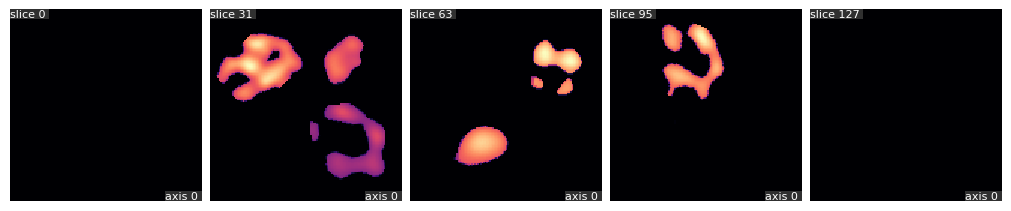

Slices of associated ground truth label:


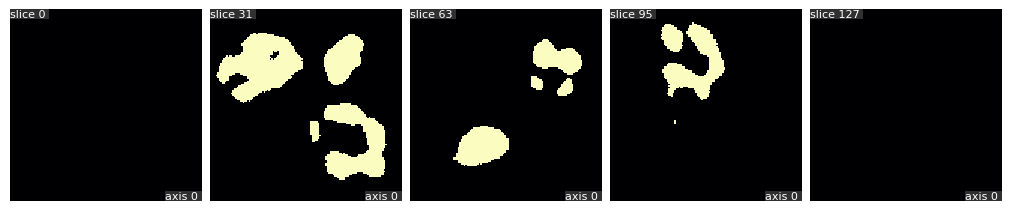

In [ ]:
# Visualize slices of volume and label
print(f"Slices of raw volume:")
qim3d.viz.slices_grid(volume, num_slices = 5, display_figure = True)

print(f"Slices of associated ground truth label:")
qim3d.viz.slices_grid(label, num_slices=5)

### **2. Build 3D UNet model**

The `qim3d` library offers a collection of pre-built deep learning models, including a 3D UNet model for segmentation. The 3D UNet model operates directly on 3D data, leveraging the volumetric structure of the data to learn complex features.

##### **2.1 Define model architecture**

Instead of specifying the model architecture from scratch, the `qim3d` library enables automatic configuration based on a specified size (*small*, *medium*, or *large*). Additionally, you can customize parameters such as dropout rate, activation function, and convolution kernel size when defining the model architecture.

In [ ]:
# Define the 3D UNet model
model = qim3d.ml.models.UNet(size = 'small')

##### **2.2 Define data augmentations**

Data augmentation is a technique used to artificially increase the training set by applying various transformations (such as rotation, flipping, cropping) to the existing data. The goal is to increase the diversity of the training set with these random (but realistic) augmentations, thus making the model more robust to subtle variations in the data.

The `qim3d` library provides a convenient way to apply pre-defined augmentation sets to the dataset splits, based on a specified level of augmentation (*light*, *moderate*, or *heavy*).

In [ ]:
# Define augmentation
augmentation =  qim3d.ml.Augmentation(
    resize = 'crop', 
    transform_train = 'light',
    transform_validation = None,
    transform_test = None,
    )

##### **2.3 Prepare dataset splits and apply augmentations**

With the model architecture and augmentation pipeline defined, we are now ready to prepare the dataset. The dataset is divided into three subsets:

- Training set
- Validation set
- Test set

We have previously specified the number of samples for the training and test sets. The validation set is created by allocating a portion of the training set, as specified by the `val_fraction` parameter. The model is trained on the training set, evaluated during training on the validation set, and finally assessed on the unseen test set. Each subset is prepared by applying the corresponding augmentations defined in the previous step to the data samples within that subset.

In [ ]:
# Define dataset splits
train_set, val_set, test_set = qim3d.ml.prepare_datasets(
    path = base_path,
    val_fraction = 0.5,
    model = model,
    augmentation = augmentation
    )

To ensure compatibility with `PyTorch`, a dataloader is prepared for each dataset split. The batch size, which specifies the number of training samples grouped together during model training, is also defined at this step.

In [ ]:
# Define data loaders
train_loader, val_loader, test_loader = qim3d.ml.prepare_dataloaders(
    train_set = train_set, 
    val_set = val_set,
    test_set = test_set,
    batch_size = 1,
    num_workers = 0, 
    )

##### **2.4 Verify model summary**

You can also obtain a summary of the model architecture to verify the model configuration. This summary provides detailed information about each layer in the model, including the layer types, output shapes, and the number of parameters. Reviewing the model summary helps ensure that the architecture is correctly defined and meets the requirements of your specific task.

In [ ]:
# Get model summary
summary = qim3d.ml.model_summary(model, train_loader)
print(summary)

Layer (type:depth-idx)                                                      Output Shape              Param #
UNet                                                                        [1, 1, 128, 128, 128]     --
├─UNet: 1-1                                                                 [1, 1, 128, 128, 128]     --
│    └─Sequential: 2-1                                                      [1, 1, 128, 128, 128]     --
│    │    └─ResidualUnit: 3-1                                               [1, 64, 64, 64, 64]       --
│    │    │    └─Conv3d: 4-1                                                [1, 64, 64, 64, 64]       1,792
│    │    │    └─Sequential: 4-2                                            [1, 64, 64, 64, 64]       --
│    │    │    │    └─Convolution: 5-1                                      [1, 64, 64, 64, 64]       --
│    │    │    │    │    └─Conv3d: 6-1                                      [1, 64, 64, 64, 64]       1,792
│    │    │    │    │    └─ADN: 6-2         

### **3. Train model**

After generating and preparing the dataset, and defining the 3D UNet model, we are ready to train the model on the data. During the training process, the model iteratively learns from the training data by adjusting its weights to minimize the difference between its predictions and the actual targets (ground truth labels). This involves feeding the input volumes through the model, calculating the loss based on the difference between the predicted and ground truth labels, and using backpropagation to update the model weights. Over multiple epochs, the model improves its ability to accurately segment the structures of interest in the 3D volumes.


##### **3.1 Define hyperparameters**

First, the hyperparameters for the training process must be defined. These include the number of epochs, learning rate, optimizer algorithm, loss function, and other relevant parameters. Increasing the number of epochs allows the model to train more extensively on the data, potentially improving its performance, but it also makes the training process longer.

In [ ]:
# Define hyperparameters
hyperparameters = qim3d.ml.Hyperparameters(
    model = model, 
    n_epochs = 10, 
    learning_rate = 5e-3, 
    loss_function = 'DiceCE',
    weight_decay = 1e-3,
    )

##### **3.2 Train model**

The model can now be trained on the training data using the specified hyperparameters. The training process is displayed as a progress bar, indicating the completion status of the specified number of epochs. After training, if `plot = True`, a plot showing the training and validation loss curves is displayed, showing how the loss decreases over the epochs as the model adjusts its weights to improve prediction accuracy.

The `checkpoint_directory` parameter allows you to save the weights of the fully trained model as a `.pth` file, enabling you to load the model later without needing to retrain it. The `qim3d.ml.load_checkpoint` function can be used to load a saved checkpoint into the model.

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch   0, train loss: 1.4618, val loss: 1.4204
Epoch   5, train loss: 1.1623, val loss: 1.1499
Model checkpoint saved at: C:\Users\s193396\dataset\model_10epochs.pth


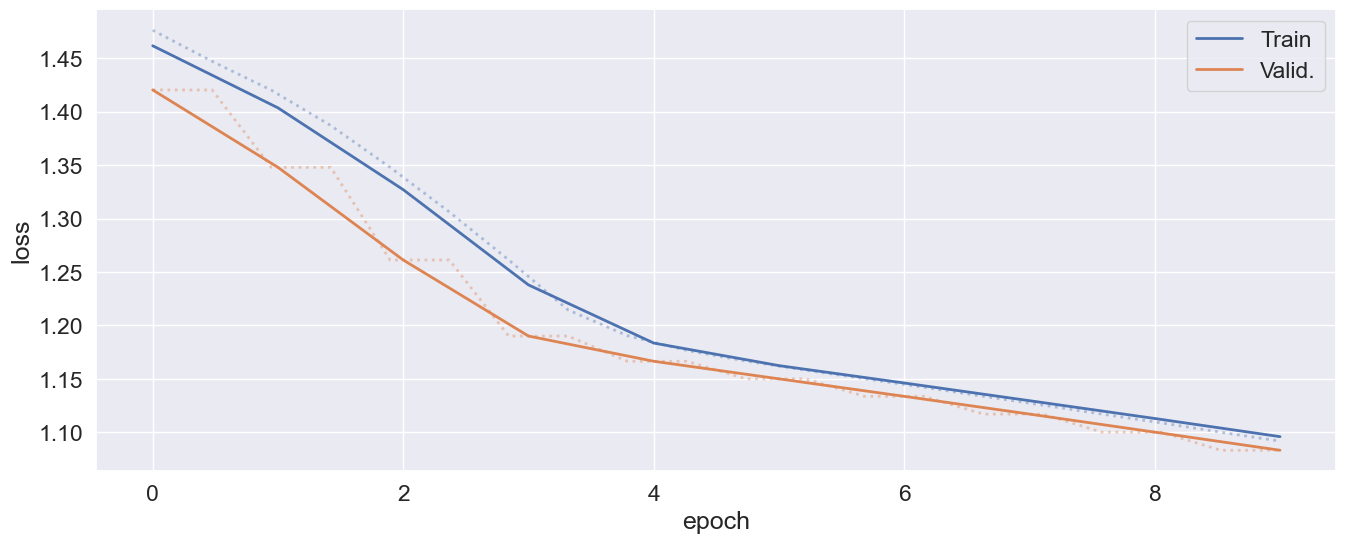

In [ ]:
# Train model
qim3d.ml.train_model(
    model = model, 
    hyperparameters = hyperparameters, 
    train_loader = train_loader, 
    val_loader = val_loader, 
    checkpoint_directory = base_path,
    plot = True,
    )

### **4. Test model**

After the model has been fully trained, its performance can be evaluated on the test set, which contains data that the model has not previously seen. This evaluation provides an indication of the model's generalization abilities, showing whether the model can make accurate predictions on new, unseen data.

Ground truth label of test image:


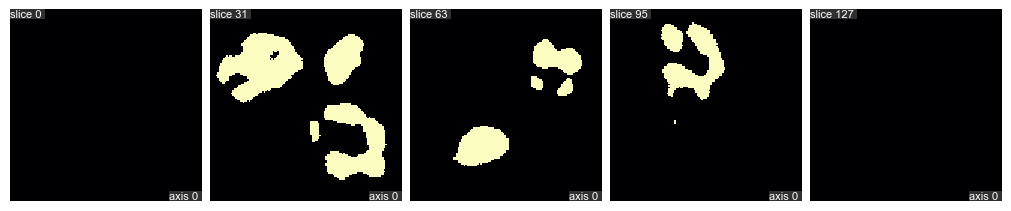

Predicted segmentation of test image:


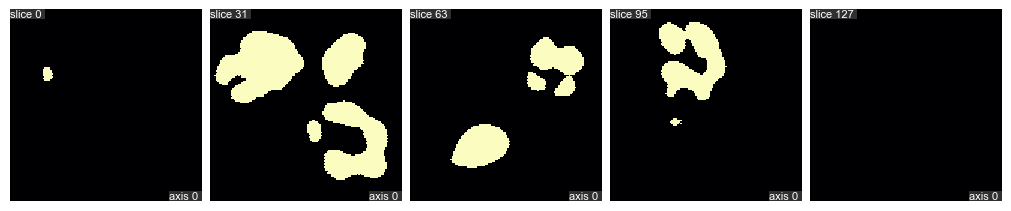

In [ ]:
# Apply the trained model to test set
results = qim3d.ml.test_model(
    model = model,
    test_set = test_set,
    )

# Get results for the first test image
volume, target, pred = results[0]

# Visualize the target segmentation (ground truth label) and the predicted segmentation
print(f"Ground truth label of test image:")
qim3d.viz.slices_grid(target, num_slices=5, display_figure=True)

print(f"Predicted segmentation of test image:")
qim3d.viz.slices_grid(pred, num_slices=5)

This concludes this notebook on deep learning segmentation of volumetric images with the `qim3d` library. We have covered the entire pipeline, from generating and preparing synthetic 3D data, defining the model architecture and augmentation pipeline, to training the 3D UNet model and evaluating its performance. By following these steps, you can apply similar techniques to your own volumetric segmentation tasks, using the power of deep learning to accurately segment structures of interest in 3D data.